# Autocodificadores

Fazer um jupyter notebook com autocodificador, a exemplo do exemplo mostrado em aula usando o Keras:

- https://t-adessowiki.fee.unicamp.br/user/aluno/notebooks/ia368z_2s2017/ia368z/deliver-keras/DenseAutoencoder.ipynb

Com as seguintes modificações:

- Utilizar o PyTorch
- Se possível, utilizar um autocodificador convolucional, porém não é imperativo
- Uma vez que o autocodificador seja treinado e o espaço bidimensional seja mostrado dos códigos dos dígitos da base de dados NMIST, gerar novas imagens:
  - mostrar algumas imagens em pontos quaisquer neste espaço bidimensional
  - dados dois pontos neste espaço, mostrar várias imagens, começando no ponto 1 e caminhando numa reta que une os dois pontos, gerar imagens associadas a pontos igualmente espaçados nessa reta, até chegar ao segundo ponto. É se esperar que os números gerados sejam interpolados entre eles.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import OrderedDict

from PIL import Image
from IPython import display

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision


from lib.pytorch_utils import DeepNetTrainer
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [17]:
data_train = torchvision.datasets.MNIST('/data/datasets/MNIST/', train=True)
data_test  = torchvision.datasets.MNIST('/data/datasets/MNIST/', train=False)

In [18]:
len(data_train), len(data_test)

(60000, 10000)

In [19]:
data_train.train_data.shape, data_test.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Treinando com pouquíssimos dados

In [20]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
    data_train.train_data = data_train.train_data[:n_train_samples]
    data_test.test_data   = data_test.test_data[:n_test_samples]

In [21]:
data_train.train_data.shape, data_test.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Visualizando algumas amostras

In [22]:
for k,(x,y) in enumerate(data_test):
    display.display(x)
    print('label=',y)
    if k > 2:
        break

label= 7


label= 2


label= 1


label= 0


## Prepara input e ouput da rede

In [23]:
from torch.utils.data import Dataset
import torchvision.transforms as trans

class AutoEncoderDataset(Dataset):
    def __init__(self, input_data, labels_data):
        super(AutoEncoderDataset, self).__init__()
        
        self.input_data = input_data.view(-1, 28, 28).type(torch.FloatTensor) / 255.0
        self.labels_data = labels_data
        
    def __len__(self):
        return self.input_data.size(0)
    
    def __getitem__(self, i):
        data = self.input_data[i]
        return (data, data)
    
    def get_label(self, i):
        return self.labels_data[i]

In [24]:
ae_data_train = AutoEncoderDataset(data_train.train_data, data_train.train_labels)
ae_data_test  = AutoEncoderDataset(data_test.test_data, data_test.test_labels)

print(len(ae_data_train))
print(len(ae_data_test))

60000
10000


## Cria os DataLoaders

In [25]:
from torch.utils.data import DataLoader

dataloaders = {
    'train': DataLoader(ae_data_train, batch_size=20, shuffle=True, num_workers=4),
    'val': DataLoader(ae_data_test, batch_size=20, shuffle=False, num_workers=4),
}

## Cria a rede

In [26]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super(MyAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(28*28, 512)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(512, 128)),
            ('relu2', nn.ReLU()),
            ('dense3', nn.Linear(128, 2))
        ]))
        
        self.decoder = nn.Sequential(OrderedDict([
            ('dense3', nn.Linear(2, 128)),
            ('relu2', nn.ReLU()),
            ('dense2', nn.Linear(128, 512)),
            ('relu1', nn.ReLU()),
            ('dense1', nn.Linear(512, 28*28))
        ]))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 28, 28)
        
        return x

## Cria o trainer

In [36]:

model = MyAutoEncoder()
model.cuda()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)

trainer = DeepNetTrainer('../../models/auto_encoder', 
                         model, 
                         criterion, 
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                         reset=True
                        )

In [37]:
import time, pickle
trainer.fit(n_epochs=10, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Starting training for 10 epochs

  1:   7.4s   T: 0.04513   V: 0.04158 best
  2:   7.4s   T: 0.04033   V: 0.03945 best
  3:   7.5s   T: 0.03894   V: 0.03831 best
  4:   7.5s   T: 0.03801   V: 0.03745 best
  5:   7.5s   T: 0.03752   V: 0.03749 
  6:   7.5s   T: 0.03711   V: 0.03716 best
  7:   7.4s   T: 0.03553   V: 0.03577 best
  8:   7.4s   T: 0.03520   V: 0.03570 best
  9:   7.4s   T: 0.03505   V: 0.03555 best
 10:   7.4s   T: 0.03490   V: 0.03555 

Model from epoch 9 saved as "../../models/auto_encoder.*", loss = 0.03555


In [38]:
test_dl = DataLoader(ae_data_test, batch_size=10, shuffle=True, num_workers=4)
iterador = iter(test_dl)

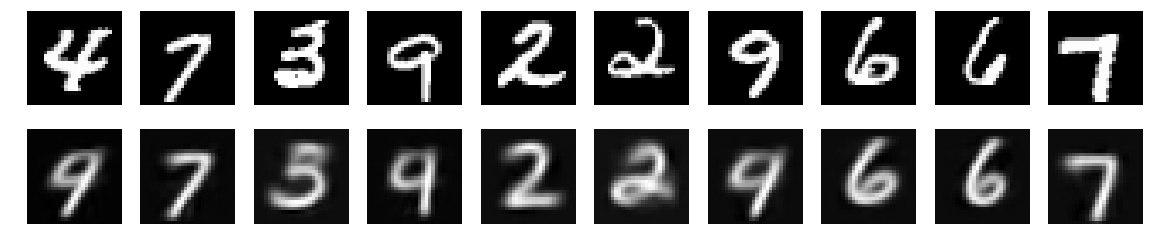

In [39]:
inputs, _ = next(iterador)
out = model(Variable(inputs.cuda()))

n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(inputs[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()


## Imagens no plano 2D

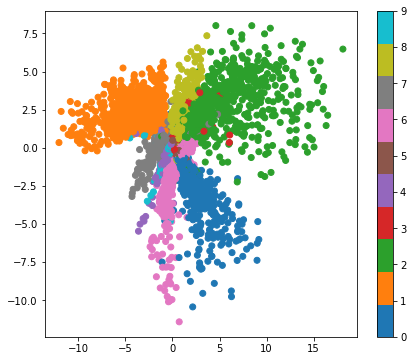

In [40]:
batch_size = 20
test_dl = DataLoader(ae_data_test, batch_size=batch_size, shuffle=False, num_workers=4)

encoded_data = np.zeros((len(ae_data_test), 2))
for i, (data, _) in enumerate(test_dl):
    inputs = data.view(-1, 28*28)
    encoded = model.encoder(Variable(inputs.cuda()))
    encoded_data[i*batch_size:(i+1)*batch_size] = encoded.data.cpu().numpy()

plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=ae_data_test.labels_data.numpy(), cmap=plt.cm.tab10)
plt.colorbar();
plt.show()

## transformação na imagem ao percorrer uma linha no espaço 2D

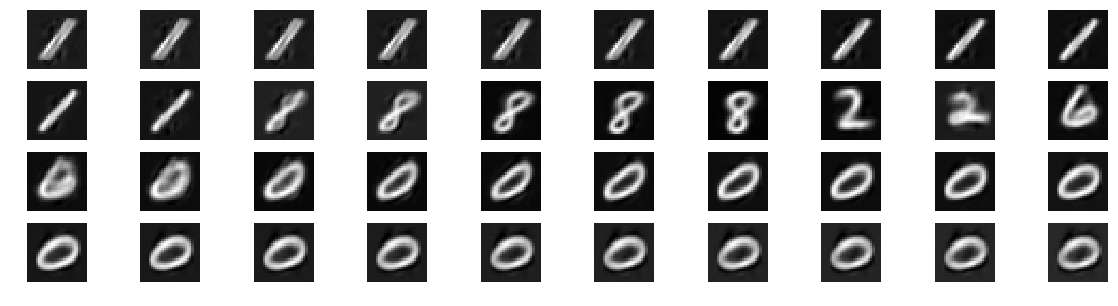

In [41]:
n = 40
x = np.linspace(-5.0, 10.0, n)
y = np.linspace(10.0, -10.0, n)

data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

out = model.decoder(Variable(data.cuda()))
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()